# Vehicle Detection and Tracking Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

## HOG 

### * Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images  
### * Train a classifier Linear SVM classifier
### * Normalize your features and randomize a selection for training and testing.

## Project Functions

In [5]:
import matplotlib.image as mpimg
import numpy as np
import cv2
from skimage.feature import hog
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features
    
# Define a function that takes an image,
# start and stop positions in both x and y, 
# window size (x and y dimensions),  
# and overlap fraction (for both x and y)
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'HSV2YCrCb':
        temp = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
        return cv2.cvtColor(temp, cv2.COLOR_RGB2YCrCb)

# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #Empty list to receive features
    img_features = []
    #Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #Append features to list
        img_features.append(spatial_features)
    #Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #Append features to list
        img_features.append(hog_features)

    #Return concatenated array of features
    return np.concatenate(img_features)
    
print("finf2")


finf2


## Generate Model and 1st Sliding Window
### Implement a sliding-window technique and use your trained classifier to search for vehicles in images.

car samples : 8792
not car samples : 8968
sample_size : 8792


d:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 6108
6.73 Seconds to train svm...
Test Accuracy of svm =  0.9886
fin


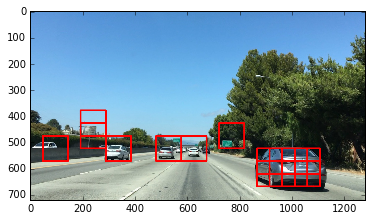

In [6]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
import pickle, pprint
%matplotlib inline

#from lesson_functions import *
# NOTE: the next import is only valid for scikit-learn version <= 0.17
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import train_test_split

# Define a function to pass an image and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #Empty list to receive positive detection windows
    on_windows = []
    #Iterate over all windows in the list
    for window in windows:
        #3Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #Predict using your classifier
        prediction = clf.predict(test_features)
        #If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows
    
    
# Read in cars and notcars
#images =glob.glob('largeset/non-vehicles/*/*.png')
cars = glob.glob('largeset/vehicles/*/*.jpg')
notcars = glob.glob('largeset/non-vehicles/*/*.jpg')

#images=('smallset/vehicles/*/*.png')
#for image in images:
    #if 'image' in image or 'extra' in image:
        #notcars.append(image)
    #else:
        #cars.append(image)

print("car samples : " +str(len(cars)))
print("not car samples : " + str(len(notcars)))

# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 8792
print("sample_size : " + str(sample_size))
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

### TODO: Tweak these parameters and see how the results change.
color_space = 'HSV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16)# Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [380, None] # Min and max in y to search in slide_window()

car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use svm
from sklearn import svm

t=time.time()
#svc = svm.SVC(C=1.5, cache_size=250, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)
# Check the training time for the svm
#svc = svm.SVC(C=0.5, cache_size=200, class_weight=None, coef0=0.0, decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear', max_iter=-1, probability=False, random_state=None, shrinking=True, tol=0.001, verbose=False)
#parameters = {'kernel':('linear', 'rbf'), 'C':[.5, 1, 1.5]}

#svc1 = svm.SVC()
#from sklearn.model_selection import GridSearchCV
#svc = GridSearchCV(svc1, parameters)

svc = LinearSVC()
svc.fit(X_train, y_train)

#print(svc.best_params_)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train svm...')
# Check the score of the svm
print('Test Accuracy of svm = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()

image = mpimg.imread('test_images/bbox-example-image.jpg')
draw_image = np.copy(image)

# Uncomment the following line if training data extracted from .png images (scaled 0 to 1 by mpimg) and the image you are searching is a .jpg (scaled 0 to 255)
#image = image.astype(np.float32)/255

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=y_start_stop, xy_window=(96, 96), xy_overlap=(0.5, 0.5))

hot_windows = search_windows(image, windows, svc, X_scaler, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)                       

window_img = draw_boxes(draw_image, hot_windows, color=(255, 0, 0), thick=6)                    

plt.imshow(window_img)
cv2.imwrite("window_img.jpg", window_img)

output = open('TDetectLinearSVM.pkl', 'wb')
# Pickle  using protocol 0.
pickle.dump(svc, output)

output = open('xscaler.pkl', 'wb')
pickle.dump(X_scaler, output)

output.close()

print("fin")


### Print Sample Image for report

Fin)


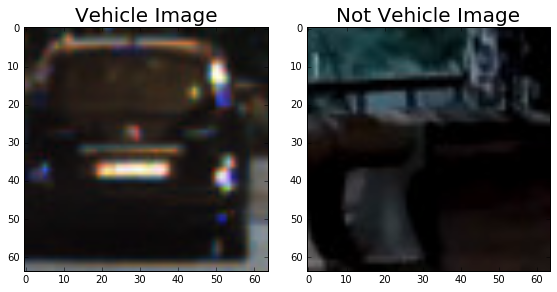

In [11]:
%matplotlib inline
democar_image = cv2.imread(cars[3000])
demonotcar_image = cv2.imread(notcars[2000])

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,8))
f.tight_layout()
ax1.imshow(democar_image)
ax1.set_title('Vehicle Image', fontsize=20)
ax2.imshow(demonotcar_image)
ax2.set_title('Not Vehicle Image', fontsize=20)

#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('SamplesV.png')
print("Fin)")

### Visulise demo data

d:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Fin)
fin


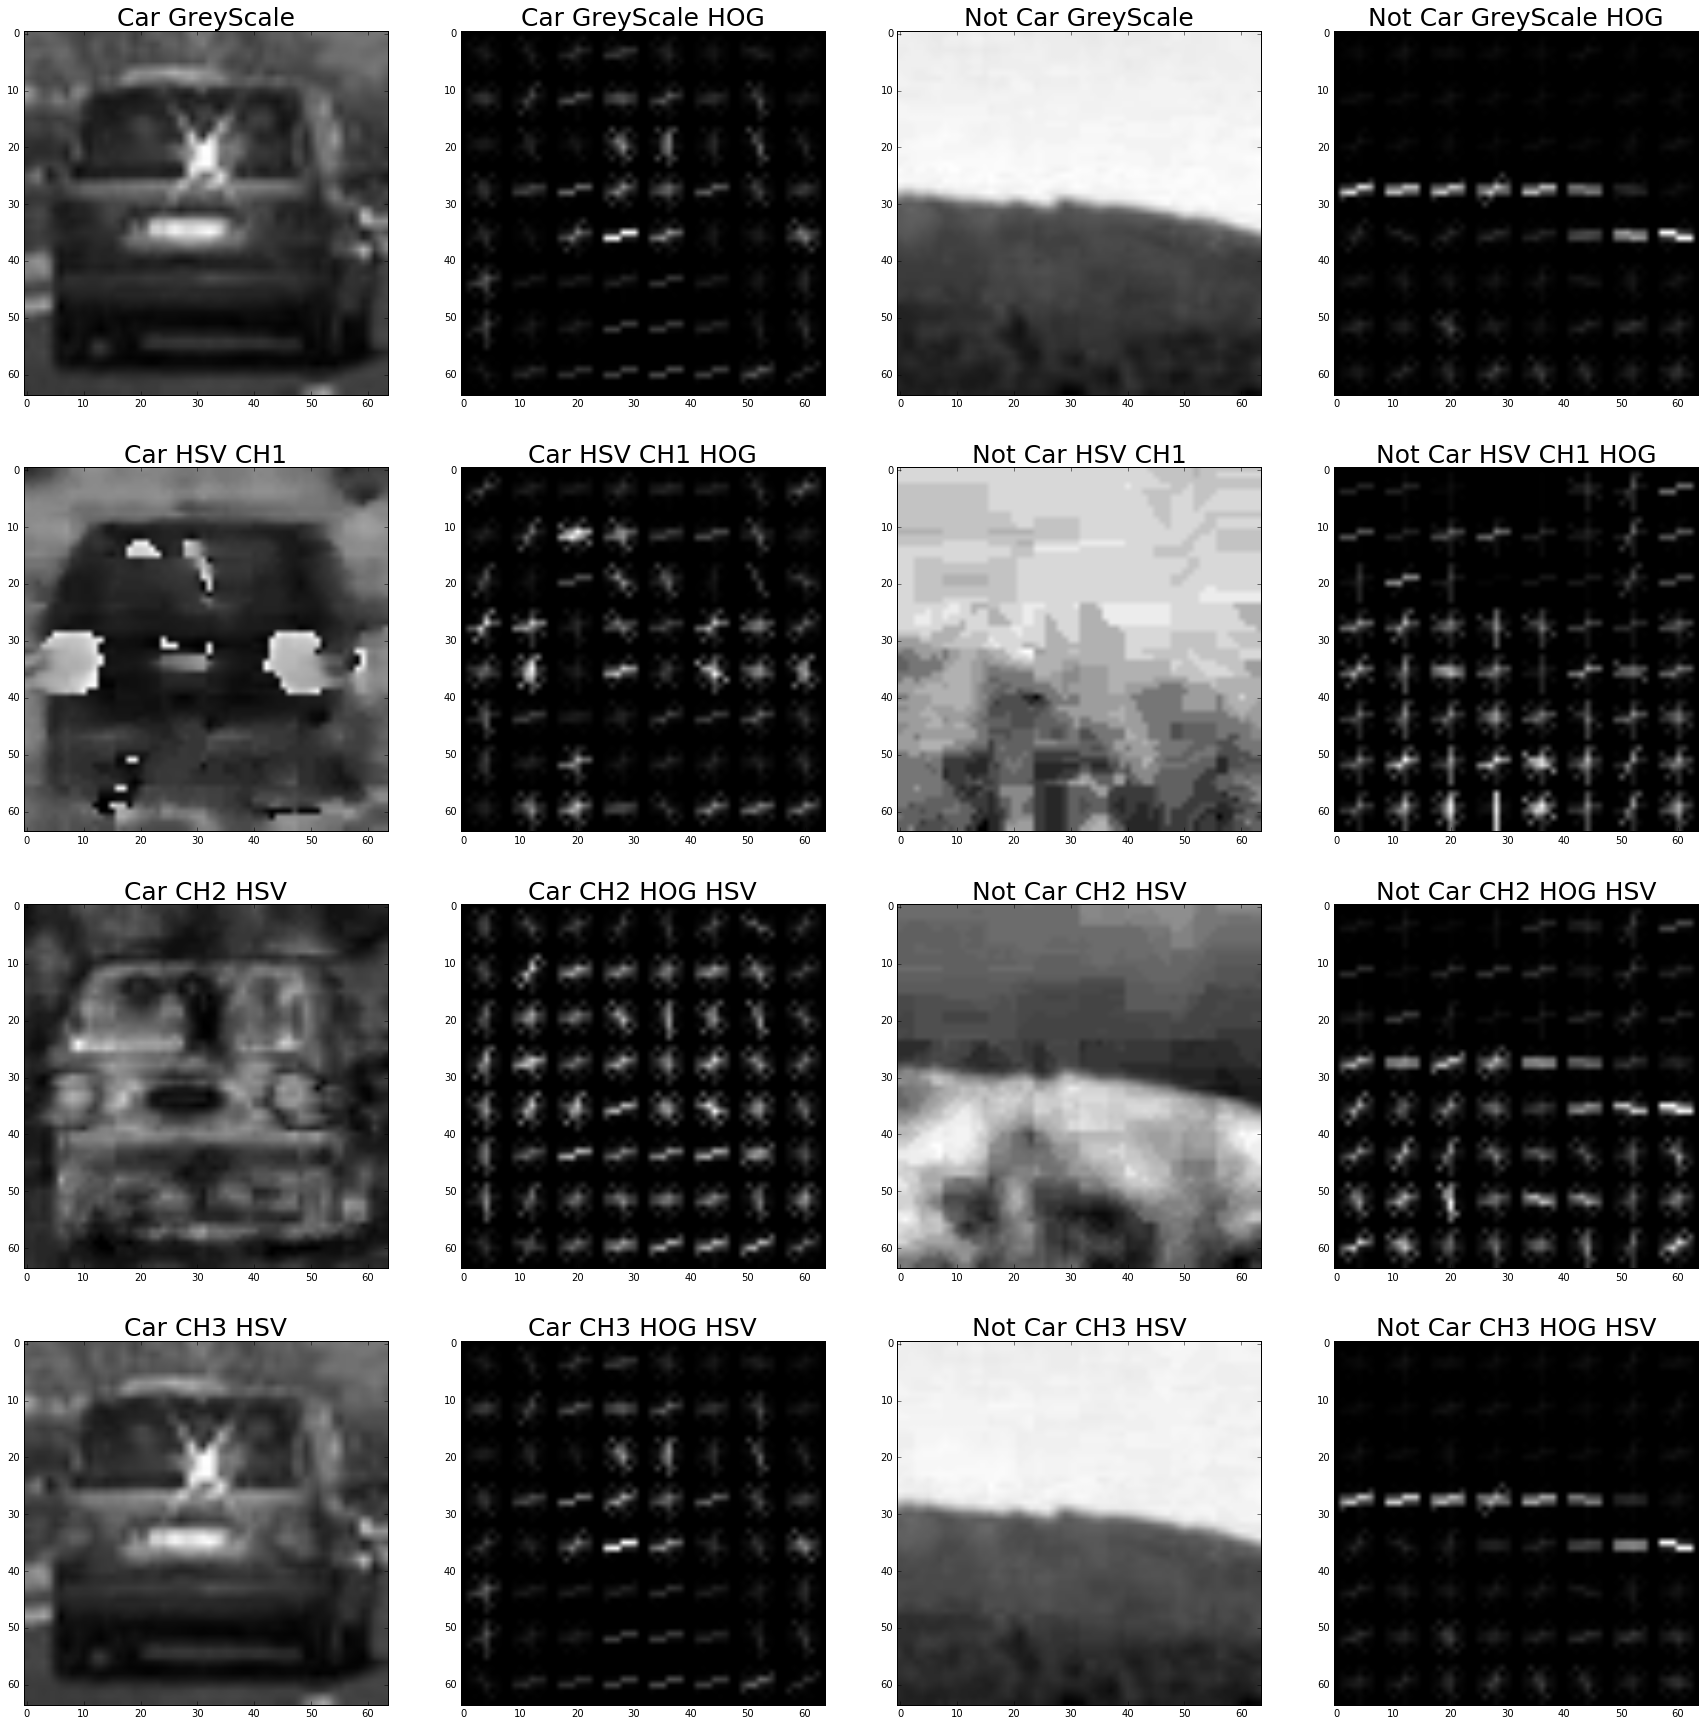

In [2]:
from skimage.feature import hog
from skimage import data, color, exposure
%matplotlib inline
pix_per_cell = 8
cell_per_block = 2
orient = 9

democar_image = cv2.imread(cars[200])
democar_image2 = cv2.cvtColor(democar_image, cv2.COLOR_RGB2HSV)

ch1 = democar_image2[:,:,0]
ch2 = democar_image2[:,:,1]
ch3 = democar_image2[:,:,2]
democar_gr = color.rgb2gray(democar_image)

demonotcar_image = cv2.imread(notcars[22])
demonotcar_image2 = cv2.cvtColor(demonotcar_image, cv2.COLOR_RGB2HSV)

nch1 = demonotcar_image2[:,:,0]
nch2 = demonotcar_image2[:,:,1]
nch3 = demonotcar_image2[:,:,2]
demonotcar_gr=color.rgb2gray(demonotcar_image)

features, hog_cgr = hog(democar_gr, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, hog_cch1 = hog(ch1, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, hog_cch2 = hog(ch2, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, hog_cch3 = hog(ch3, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)


features, hog_ncgr = hog(demonotcar_gr, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, hog_ncch1 = hog(nch1, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, hog_ncch2 = hog(nch2, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)
features, hog_ncch3 = hog(nch3, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=True, feature_vector=False)

f, ax = plt.subplots(4, 4, figsize=(30,30))
#f.tight_layout()

#axes[0, 0].imshow(z, cmap=cmap)
#axes[0, 0].set(xlabel='Colormapped Data')
ax[0, 0].set_title('Car GreyScale', fontsize=25)    
ax[0, 0].imshow(democar_gr,cmap="gray")
ax[0, 1].set_title('Car GreyScale HOG', fontsize=25)
ax[0, 1].imshow(hog_cgr,cmap="gray")
ax[0, 2].set_title('Not Car GreyScale', fontsize=25)    
ax[0, 2].imshow(demonotcar_gr,cmap="gray")
ax[0, 3].set_title('Not Car GreyScale HOG', fontsize=25)
ax[0, 3].imshow(hog_ncgr,cmap="gray")

ax[1, 0].set_title('Car HSV CH1', fontsize=25)    
ax[1, 0].imshow(ch1,cmap="gray")
ax[1, 1].set_title('Car HSV CH1 HOG', fontsize=25)
ax[1, 1].imshow(hog_cch1,cmap="gray")
ax[1, 2].set_title('Not Car HSV CH1', fontsize=25)    
ax[1, 2].imshow(nch1,cmap="gray")
ax[1, 3].set_title('Not Car HSV CH1 HOG', fontsize=25)
ax[1, 3].imshow(hog_ncch1,cmap="gray")

ax[2, 0].set_title('Car CH2 HSV', fontsize=25)    
ax[2, 0].imshow(ch2,cmap="gray")
ax[2, 1].set_title('Car CH2 HOG HSV', fontsize=25)
ax[2, 1].imshow(hog_cch2,cmap="gray")
ax[2, 2].set_title('Not Car CH2 HSV', fontsize=25)    
ax[2, 2].imshow(nch2,cmap="gray")
ax[2, 3].set_title('Not Car CH2 HOG HSV', fontsize=25)
ax[2, 3].imshow(hog_ncch2,cmap="gray")

ax[3, 0].set_title('Car CH3 HSV', fontsize=25)    
ax[3, 0].imshow(ch3,cmap="gray")
ax[3, 1].set_title('Car CH3 HOG HSV', fontsize=25)
ax[3, 1].imshow(hog_cch3,cmap="gray")
ax[3, 2].set_title('Not Car CH3 HSV', fontsize=25)    
ax[3, 2].imshow(nch3,cmap="gray")
ax[3, 3].set_title('Not Car CH3 HOG HSV', fontsize=25)
ax[3, 3].imshow(hog_ncch3,cmap="gray")



#ax2.imshow(demonotcar_image)
#ax2.set_title('Sample Not Image', fontsize=50)

#plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.savefig('Samples.png')
print("Fin)")

print("fin")

## Hog Sub-sampling Window Search

alive
scale : 0.75


d:\ProgramData\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


scale : 1.0
scale : 1.25
scale : 1.5
scale : 1.75
scale : 2.0
scale : 2.25
700
450


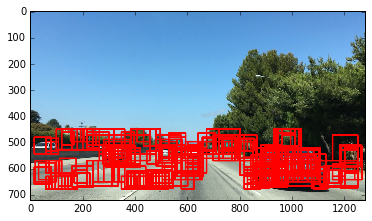

In [151]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from sklearn.preprocessing import StandardScaler
%matplotlib inline

svc = pickle.load( open("TDetectLinearSVM.pkl", "rb" ) )
X_scaler = pickle.load( open("xscaler.pkl", "rb" ) )

orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
spatial_size = (16, 16)# Spatial binning dimensions
hist_bins = 16    # Number of histogram bins

img = mpimg.imread('test_images/bbox-example-image.jpg')

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    #img = img.astype(np.float32)/255
    
    box_list =[]
    
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='HSV2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                boxsingle = [[xbox_left, ytop_draw+ystart],[xbox_left+win_draw,ytop_draw+win_draw+ystart]]
                box_list.append(boxsingle)
               
    return draw_img, box_list

boxList=[]
boxListadd = []
print("alive")
ystart = 450
ystop = 700
scale = 1.0
   
for index, i in enumerate(range(75, 250, 25)):    
    scale = i/100
    print("scale : " + str(scale))
    out_img, boxListT = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    if index == 0:
        boxList = boxListT
    elif index >0 and index <4: 
        boxList= np.concatenate([boxList,boxListT])
    boxListadd = boxListadd + boxListT
    ystart = ystart + 0
    ystop = ystop + 0
    
boxes=[]

for box in boxList:
    
    boxes.append([tuple(box[0]),tuple(box[1])])
    

#draw_img = draw_labeled_bboxes(np.copy(out_img), boxListT)
window_img = draw_boxes(img, boxes, color=(255, 0, 0), thick=6)                    



print(ystop)
print(ystart)

plt.imshow(window_img)

318
318
2


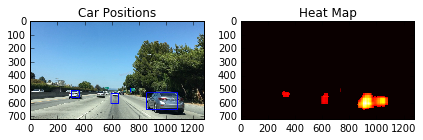

In [193]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
#box_list = pickle.load( open( "bbox_pickle.p", "rb" ))

box_list = boxListadd

print(len(box_list))

# Read in image similar to one shown above 
image = mpimg.imread('test_images/bbox-example-image.jpg')
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

# Add heat to each box in box list
heat = add_heat(heat,box_list)
print(len(box_list))    
# Apply threshold to help remove false positives
heat = apply_threshold(heat,14)

# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(image), labels)

print(len(labels))

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

plt.savefig('pipeline.png')


## Define Process Image

In [225]:
def process_image(image,RetHeat = False):
    
    X_scaler = pickle.load( open("xscaler.pkl", "rb" ) )
    img=image
    
    boxList=[]

    ystart = 350
    ystop = 600
    scale = 2.0

    for index, i in enumerate(range(75, 250, 25)):    
        scale = i/100

        out_img, boxListT = find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        boxList = boxList + boxListT
        ystart = ystart + 0
        ystop = ystop + 5
    
    box_list = boxList
    image = img
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    #print(len(box_list))
    
    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heatt = apply_threshold(heat,16)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heatt, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    if RetHeat == True:
        return draw_img, heatmap, box_list
    else:
         return draw_img


print("fin")

fin


### Output Video

In [199]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from moviepy.editor import VideoFileClip
from IPython.display import HTML
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
from scipy.ndimage.measurements import label

#%matplotlib qt
# Read in the saved camera matrix and distortion coefficients
# These are the arrays you calculated using cv2.calibrateCamera()
svc = pickle.load( open("TDetectLinSVMrbfjpgC1p5HSV.pkl", "rb" ) ) 

print("strt")
vid_output = 'project_out.mp4'
clip1 = VideoFileClip("proj2sec.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(vid_output, audio=False)


strt
[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


100%|██████████████████████████████████████████████████████████████| 54/54 [03:31<00:00,  3.74s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_out.mp4 

Wall time: 3min 32s


### Ouput Some frames from video section

In [165]:
import cv2
smallcap = cv2.VideoCapture('proj2sec.mp4')
success,image = vidcap.read()
index = 0
success = True
while success and index <20:
    print("frame : " +str(count))
    success,image = vidcap.read()
    cv2.imwrite("temp/frame%d.jpg" % index, image)     
    index += 1

frame : 0
frame : 1
frame : 2
frame : 3
frame : 4
frame : 5
frame : 6
frame : 7
frame : 8
frame : 9
frame : 10
frame : 11
frame : 12
frame : 13
frame : 14
frame : 15
frame : 16
frame : 17
frame : 18
frame : 19


0
1
2
3
4
5
[[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
Fin)


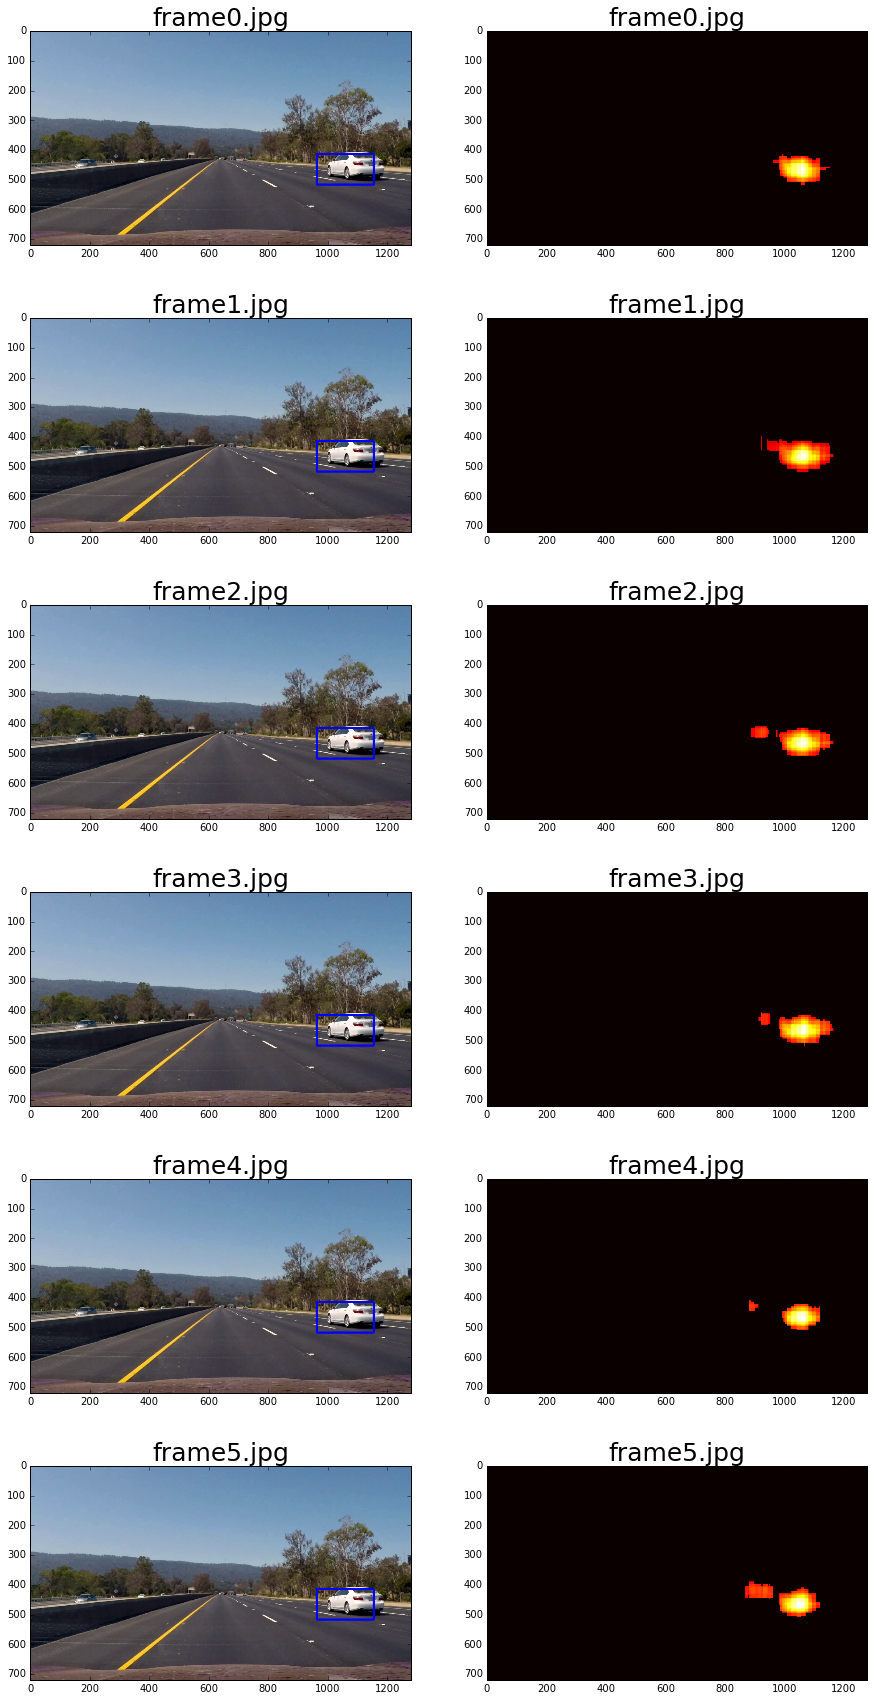

In [256]:
# Reference https://stackoverflow.com/questions/33311153/python-extracting-and-saving-video-frames
count = 0
images=[]
heatmaps=[]
heats=[]
f, ax = plt.subplots(6, 2, figsize=(15,30))



while count < 6:
    print(count)
    name = ("frame%d.jpg" % count)
    imaget = mpimg.imread("temp/frame%d.jpg" % count)
    heat = np.zeros_like(imaget[:,:,0]).astype(np.float)
    im,hm, bl =  process_image(imaget, True)
    if count == 0:
        boxList = boxListT
    elif index >0 and index <4: 
        boxList= np.concatenate([boxList,boxListT])
    images.append(im)
    heats.append(h)
    
    ax[count, 0].set_title(name, fontsize=25)    
    ax[count, 0].imshow(images[0],cmap="gray")
    ax[count, 1].set_title(name, fontsize=25)
    ax[count, 1].imshow(hm, cmap="hot")
    count = count+1
    
print(h)

heat = add_heat(heat,boxList)

# Apply threshold to help remove false positives
heatt = apply_threshold(heat,16)

# Visualize the heatmap when displaying    
heatmap = np.clip(heatt, 0, 255)

# Find final boxes from heatmap using label function
labels = label(heatmap)


from scipy.ndimage.measurements import label
labels = label(heats)

plt.savefig('heats.png')
print("Fin)")


### Integrated heatmap from all six frames

1 cars found
Fin)


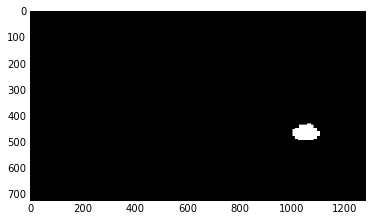

In [257]:
count = 0
images=[]
heatmaps=[]
heats=[]
boxList=[]

while count < 6:
    #print(count)
    imaget = mpimg.imread("temp/frame%d.jpg" % count)
    im,hm, boxListT =  process_image(imaget, True)
    if count == 0:
    
        boxList = boxListT
    elif count >0 : 
        boxList= np.concatenate([boxList,boxListT])
    images.append(im)
    heats.append(h)

    count = count+1
    

from scipy.ndimage.measurements import label
heat = add_heat(heat,boxList)
heatt = apply_threshold(heat,190)
# Visualize the heatmap when displaying    
heatmap = np.clip(heatt, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
#print(len(heatt))

print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')

plt.savefig('heats.png')
print("Fin)")


### Bounding boxes are drawn onto the last frame in the series

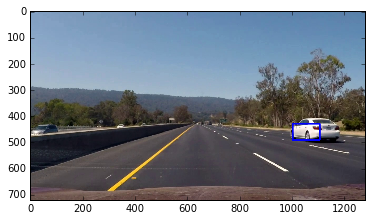

In [258]:
imaget = mpimg.imread("temp/frame5.jpg" )

draw_img = draw_labeled_bboxes(np.copy(imaget), labels)
plt.imshow(draw_img)

## Work in Progress

In [185]:
global mapo
mapo=[]

1280


In [201]:
def globvar(number):
    mapo.append(number)
    
    return mapo

In [205]:
ft = globvar(2)
print(ft)

[2, 2, 2]
